# 此份代码来源
https://www.kaggle.com/aralsarrafi/flowers-resnet50-tensorflow
# 待学习链接
https://blog.csdn.net/wf592523813/article/details/94478006?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param

https://www.baidu.com/link?url=5VywaI7fOaH1nVJXM8oTTZ5fO_bTA2WtSrEMOdY_YrfcGDTpAQ3wSwNdIBnaIAnOeOiv9Y4EJo4xhASOcJCnra&wd=&eqid=a9c857cc000428a7000000065faf5585

https://www.cnblogs.com/hutao722/p/10008581.html 【从这里来看，依然是个尝试的过程？】

https://www.zhihu.com/question/273633408/answer/369134332 【关于ImageNet数据集】

https://www.cnblogs.com/BlueBlueSea/p/11067521.html 【对于dropout的别人的尝试】

https://blog.csdn.net/qq_27292549/article/details/81092653 【不确定值不值得看，大概率不值得】

In [1]:
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras import backend
# from numba import cuda
from keras.models import load_model

d:\other_all\application\python\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\other_all\application\python\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\other_all\application\python\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\other_all\application\python\lib\site-packages\tensorflow\python\framework\dtypes.

In [14]:
train_path = r'flowers_google'
labels_path = "flowers_label.csv"
ids_path = "flowers_idx.csv"

In [15]:
def PrepareAnnotation(ids_path, labels_path, train_path):
    
    ids = pd.read_csv(ids_path)
    labels  = pd.read_csv(labels_path)
    
    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable
    
    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes+=1
        
    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]
    
    image_pathes = []
    targets = []
    
    for key, value in annotation_dict.items():
        
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)
    
    return image_pathes, targets, num_classes

In [16]:
image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)

In [17]:
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True)
print("num_train = ", len(x_train))
print("num_valid = ", len(x_val))

num_train =  13172
num_valid =  3293


In [18]:
def SelectSamplesForEachClass(x_train, y_train, num_examples):
    class_image_path = {}
    
    for i in range(len(y_train)):
        if (y_train[i] in class_image_path):
            if len(class_image_path[y_train[i]]) < num_examples:
                   class_image_path[y_train[i]].append(x_train[i])
        
        else:
            class_image_path[y_train[i]] = [x_train[i]]        
    
    return class_image_path

# 仅仅是展示数据集中的某些图像

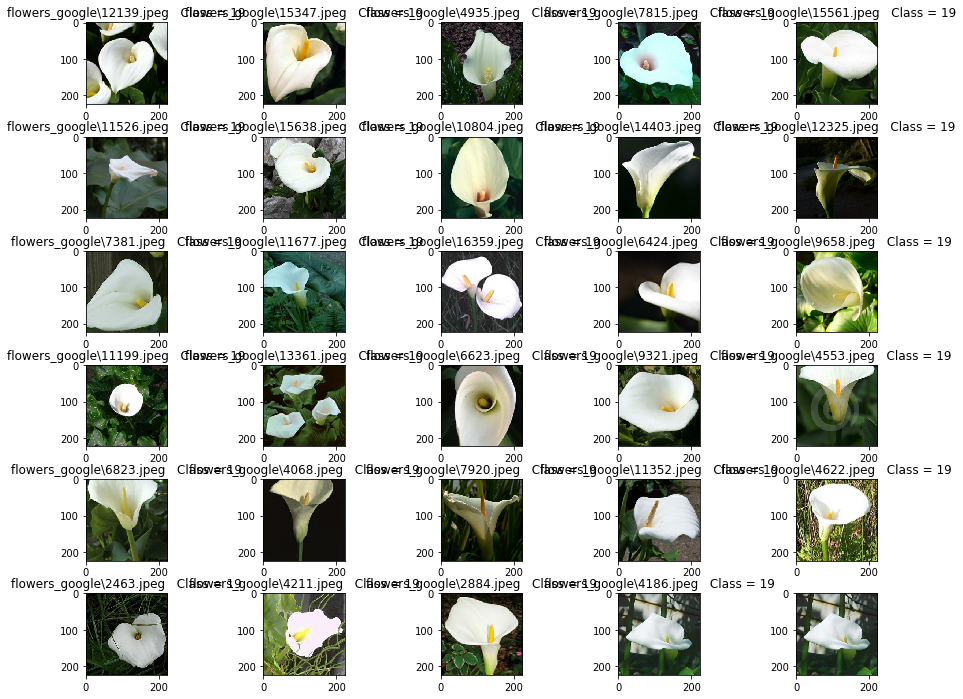

In [19]:
class_label = 19 # Try other Classes.
num_examples_to_show = 30

class_image_path_ = SelectSamplesForEachClass(x_train, y_train, num_examples_to_show)

images = class_image_path_[class_label]

fig, ax = plt.subplots(6,5, figsize=(15,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax = ax.ravel()
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    
    plt.imshow(img)
    
    title_txt = image.split("/")[-1] + "   " + "Class = " + str(class_label)
    ax[i].set_title(title_txt)
    i+=1

In [20]:
def Generator(X, Y, batch_size):
    
    while True:
        indexes = np.random.choice(len(X), batch_size)
        x = []
        y = []
    
        for index in indexes:
            x.append(X[index]) 
            y.append(Y[index])
        
        x_batch = []
        
        y_batch = K.utils.to_categorical(y, num_classes= num_classes)
        
        for i in range(len(x)):
            image = cv2.imread(x[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = K.applications.resnet50.preprocess_input(image)
            x_batch.append(image)
        
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [21]:
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights="imagenet", input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

In [22]:
model = ResNet50Model()

Instructions for updating:
Colocations handled automatically by placer.


d:\other_all\application\python\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [25]:
# Freez first 168 Layers Except the Batch Normalization ones.
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True
    
    if isinstance(layer, K.layers.BatchNormalization):
        # Set Batch Norm momentun to 0.9 to faster adapt to the new DataSet.
        layer.momentum = 0.9

for layer in model.layers[:num_feerezed_layer]:
    
    if not isinstance(layer, K.layers.BatchNormalization):
        layer.trainable = False
        
# Check if the trainable layers are set Correctly
for layer in model.layers:
    print(layer.name, " ", "trainable = ", layer.trainable)

input_1   trainable =  False
conv1_pad   trainable =  False
conv1   trainable =  False
bn_conv1   trainable =  True
activation_1   trainable =  False
pool1_pad   trainable =  False
max_pooling2d_1   trainable =  False
res2a_branch2a   trainable =  False
bn2a_branch2a   trainable =  True
activation_2   trainable =  False
res2a_branch2b   trainable =  False
bn2a_branch2b   trainable =  True
activation_3   trainable =  False
res2a_branch2c   trainable =  False
res2a_branch1   trainable =  False
bn2a_branch2c   trainable =  True
bn2a_branch1   trainable =  True
add_1   trainable =  False
activation_4   trainable =  False
res2b_branch2a   trainable =  False
bn2b_branch2a   trainable =  True
activation_5   trainable =  False
res2b_branch2b   trainable =  False
bn2b_branch2b   trainable =  True
activation_6   trainable =  False
res2b_branch2c   trainable =  False
bn2b_branch2c   trainable =  True
add_2   trainable =  False
activation_7   trainable =  False
res2c_branch2a   trainable =  False


In [27]:
checkpoint = ModelCheckpoint('models/Best_Model.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

In [28]:
model.compile(loss='categorical_crossentropy', optimizer = K.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

In [31]:
batch_size = 16
model.fit(Generator(x_train, y_train, batch_size), 
          steps_per_epoch=len(x_train)//batch_size,
          epochs= 4,
          validation_data=Generator(x_val, y_val, batch_size),
          validation_steps=len(x_val) // batch_size,
          callbacks=[checkpoint])

Epoch 1/4
823/823 [==============================] - 361s 439ms/step - loss: 1.0408 - accuracy: 0.7497 - val_loss: 0.6003 - val_accuracy: 0.8268

Epoch 00001: val_accuracy improved from -inf to 0.82683, saving model to models/Best_Model.h5
Epoch 2/4
823/823 [==============================] - 347s 421ms/step - loss: 0.3809 - accuracy: 0.8963 - val_loss: 1.0947 - val_accuracy: 0.8628

Epoch 00002: val_accuracy improved from 0.82683 to 0.86280, saving model to models/Best_Model.h5
Epoch 3/4
823/823 [==============================] - 347s 421ms/step - loss: 0.2467 - accuracy: 0.9313 - val_loss: 0.8030 - val_accuracy: 0.8543

Epoch 00003: val_accuracy did not improve from 0.86280
Epoch 4/4
823/823 [==============================] - 347s 421ms/step - loss: 0.1632 - accuracy: 0.9531 - val_loss: 0.3196 - val_accuracy: 0.8756

Epoch 00004: val_accuracy improved from 0.86280 to 0.87561, saving model to models/Best_Model.h5


In [ ]:
model = load_model("Best_Model.h5")
test_accuracy = model.evaluate_generator(Generator(x_val, y_val, batch_size), len(x_val) // batch_size)[1]
print(test_accuracy)

In [23]:
def VisualizePrediction(path, gt_label):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    
    image = K.applications.resnet50.preprocess_input(image)
    image = np.expand_dims(image, axis = 0)
    
    probabilities = model.predict(image)
    predicted_label = np.argmax(probabilities, axis = 1)
    
    title_txt = "Prediction = " + str(predicted_label[0]) + "     " + "gt = " + str(gt_label)
    plt.title(title_txt)

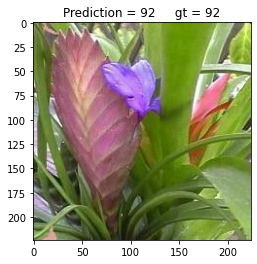

In [24]:
sample = 500 # Try different Samples
image_path = x_val[sample]
gt_label = y_val[sample]

# Make Predictions on Training Data set.
# image_path = x_train[sample]
# gt_label = y_train[sample]

VisualizePrediction(image_path, gt_label)